## Exercise 1

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

rating_col = ["user_id", "movie_id", "rating", "timestamp"]
user_col = ["user_id", "age", "gender", "occupation", "zip_code"]
item_col = ["movie_id", "movie_title", "rel_date", "vrel_date", "imdb", "unknown", "action", 
            "adventure", "animation", "children", "comedy", "crime", "docu", "drama", "fantasy",
            "noir", "horror", "musical", "mystery", "romance", "scifi", "thriller", "war", "western"]



rt_df = pd.read_csv('u.data', names = rating_col, sep = '\t')
us_df = pd.read_csv('u.user', names = user_col, sep = '|')
it_df = pd.read_csv('u.item', names = item_col, sep = '|', index_col = False)
usr_df = pd.merge(rt_df, us_df, on = "user_id")
user_df = pd.merge(usr_df, it_df, on = "movie_id")

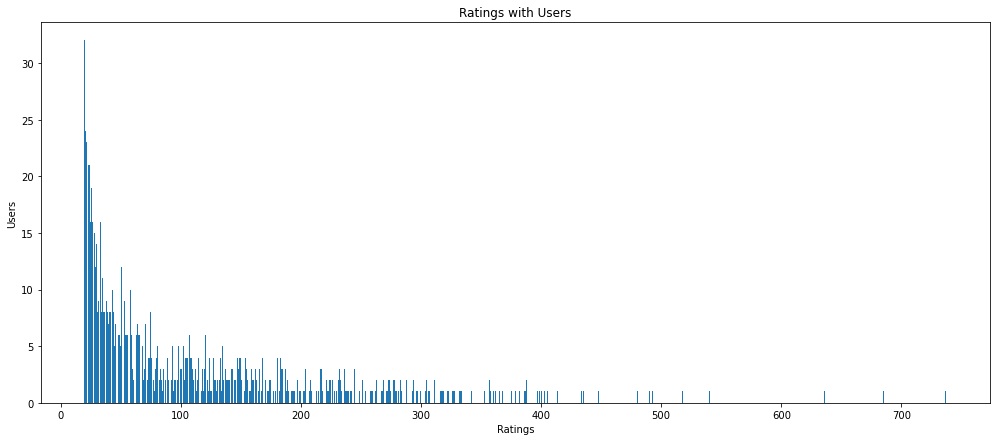

In [57]:
# 1.
us_rt_df = user_df.groupby("user_id").count()
us_rt_df =  us_rt_df.reset_index()
np_rat = us_rt_df.rating.to_numpy()
rating, user = np.unique(np_rat, return_counts = True)
plt.figure(figsize = (17, 7))
plt.bar(rating, user)
plt.xlabel('Ratings')
plt.ylabel('Users')
plt.title('Ratings with Users')
plt.show()

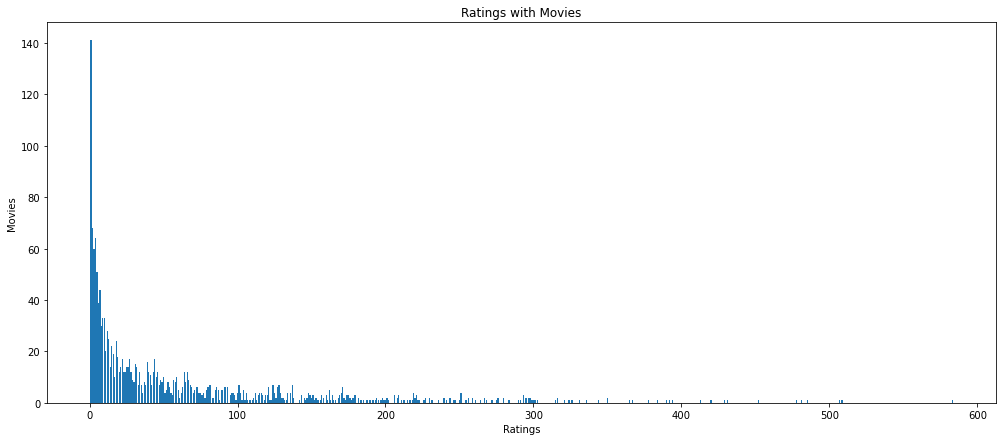

In [58]:
#2.
us_mv_df = user_df.groupby("movie_id").count()
us_mv_df =  us_mv_df.reset_index()
np_rat2 = us_mv_df.rating.to_numpy()
rating, movie = np.unique(np_rat2, return_counts = True)
plt.figure(figsize = (17, 7))
plt.bar(rating, movie)
plt.xlabel('Ratings')
plt.ylabel('Movies')
plt.title('Ratings with Movies')
plt.show()

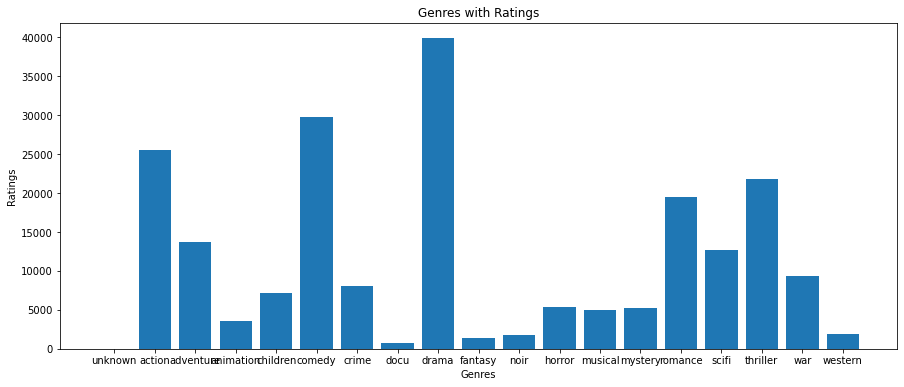

In [59]:
#3.
drp_cols = ["user_id", "movie_id", "rating", "timestamp", "age",
              "gender", "occupation", "zip_code", "movie_title",
              "rel_date", "vrel_date", "imdb"]
tmp_df = user_df.drop(drp_cols, axis = 1)
rws = tmp_df.to_numpy()
gCol = tmp_df.columns.to_numpy()
summ = np.sum(rws, axis = 0)
plt.figure(figsize = (15, 6))
plt.bar(gCol, summ)
plt.xlabel('Genres')
plt.ylabel('Ratings')
plt.title('Genres with Ratings')
plt.show()

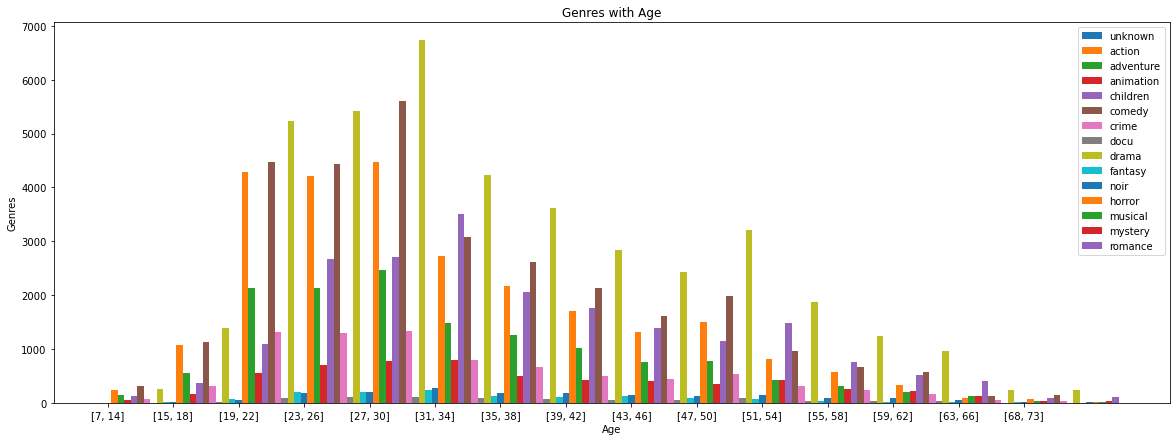

In [25]:
#4. 
drp_cols2 = ["user_id", "movie_id", "rating", "timestamp", 
              "gender", "occupation", "zip_code", "movie_title",
              "rel_date", "vrel_date", "imdb"]
tmp_df2 = user_df.drop(drp_cols2, axis = 1)
tmp_df2 = tmp_df2.groupby('age').sum()
rws2 = tmp_df2.to_numpy()
np_gen = tmp_df2.columns.to_numpy()
np_age = tmp_df2.index.to_numpy()

a_rws = np.append(np_age.reshape(rws2.shape[0], 1), rws2, axis = 1)
a_grp = np.array_split(a_rws, 15, axis = 0)
a_gnr = np.full((len(a_grp), len(np_gen)), dtype = int, fill_value = 0)
a_br = np.zeros((len(a_grp), 2), dtype = int)
for i in range(len(a_grp)):
    a_gnr[i, :] = (np.sum(a_grp[i], axis = 0)[1: ])
    a_br[i, 0] = np.min(a_grp[i][:, 0])
    a_br[i, 1] = np.max(a_grp[i][:, 0])
plt.figure(figsize = (20, 7))
x = np.arange(len(a_gnr), dtype = float)
for b in range(len(a_br)):
    plt.bar(x, a_gnr[:, b], width = 0.1, label = np_gen[b])
    x = x + 0.1
plt.xticks(np.arange(len(a_br)), a_br.tolist())
plt.legend()
plt.xlabel('Age')
plt.ylabel('Genres')
plt.title('Genres with Age')
plt.show()

## Exercise 2

In [61]:
rt_df2 = rt_df.drop('timestamp', axis = 1)
rt_df2 = rt_df2.sort_values(by = ['user_id', 'movie_id'])

rt_df2_np = rt_df2.to_numpy()

matX = np.full((len((np.unique(rt_df2_np[:, 0]))), len((np.unique(rt_df2_np[:, 1])))), fill_value = np.nan)
for r in (np.unique(rt_df2_np[:, 0])):
    user = rt_df2_np[rt_df2_np[:, 0] == r, 1:]
    for c in (np.unique(rt_df2_np[:, 1])):
        if (user[user[:, 0] == c, 0]) == c:
            matX[r - 1, c - 1] = user[user[:, 0] == c, 1]

matXn = matX / np.nansum(matX)

def train_val_test_split(matA, distr):
    m = 0
    r, c = matA.shape
    trainn = np.full(matA.shape, fill_value = np.nan)
    val = np.full(matA.shape, fill_value = np.nan)
    testt = np.full(matA.shape, fill_value = np.nan)
    for i in range(r):
        for j in range(c):
            if np.isnan(matA[i, j]) == False:
                if m % 10 < int(distr[0] * 10):
                    trainn[i, j] = matA[i, j]
                if m % 10 >= int(distr[1] * 10): 
                    testt[i, j] = matA[i, j]
                if m % 10 < int(distr[1] * 10) and m % 10 >= int(distr[0] * 10):
                    val[i, j] = matA[i, j]
                m = m + 1
    return trainn, val, testt

l = matXn.shape[0]
np.random.seed(3116)
np.random.shuffle(matX)
distr = [0.8, 0.9]
np_train, np_val, np_test = train_val_test_split(matXn, distr)


In [34]:
def factor_m(tr_r, tr_k, n, lr, lmb):
    rw, cl = tr_r.shape
    r1 = np.random.rand(rw, tr_k)
    r2 = np.random.rand(cl, tr_k)
    r2 = r2.T
    errorList = []
    for n in range(n):
        err = 0
        for i in range(tr_r.shape[0]):
            for j in range(tr_r.shape[1]):
                if math.isnan(tr_r[i, j]) == False:
                    e_rc = tr_r[i, j] - np.dot(r1[i, :], r2[:, j])
                    r1[i, :] = r1[i, :] + lr * (e_rc * r2[:, j] - lmb * r1[i, :])
                    r2[:, j] = r2[:, j] + lr * (e_rc * r1[i, :] - lmb * r2[:, j])
                    err = err + (np.square(tr_r[i, j] - np.dot(r1[i, :], r2[:, j]))) + np.sum((lmb / 2) * (np.square(r1[i, :]) + np.square(r2[:, j])))
        errorList.append(np.sqrt(err / tr_r.size))
        if err < 0.001:
            break
    return r1, r2.T, errorList


In [40]:
params = {
    "k": [0.2, 0.4, 0.6, 0.8, 0.9], 
    "lr": [2e-3, 3e-4, 4e-4, 1e-5, 6e-5],
    "lmb": [5e-3, 1e-4, 5e-4, 1e-5, 5e-5]
}
paramList = {}
params_np = np.vstack((list(params.values())))
n = 40
tr_tmp = np_train
tst_tmp = np_test
val_tmp = np_val

for i in range(params_np.shape[0]):
    np.random.shuffle(params_np.T[:, i])

for i in range(params_np.shape[1]):
    params = params_np[:, i]
    tr_p, trr_q, l_train = factor_m(tr_tmp, int(tst_tmp.shape[0] * float(params[0].item())), n, float(params[1].item()), float(params[2].item()))
    R_train_hat = np.dot(tr_p, trr_q.T)
    rmse_val = np.sqrt(np.nansum(np.square(R_train_hat - val_tmp)) / R_train_hat.size)
    paramList[rmse_val] = [params, l_train[-1], R_train_hat]

opt_p = paramList[np.min(list(paramList.keys()))]

print("Optimized params (K, lr, lmb) : ", opt_p[0][0], ", ", opt_p[0][1], ", " , opt_p[0][2], ")")
print("Val RMSE: ", np.min(list(paramList.keys())))
print("Test RMSE: ", np.sqrt(np.nansum(np.square(opt_p[2] - tst_tmp)) / opt_p[2].size))

Optimized params (K, lr, lmb) :  0.4 ,  0.0003 ,  0.005 )
Val RMSE:  0.28646238811905333
Test RMSE:  0.2647379693641463
Wall time: 52min 8s


## Exercise 3

In [48]:
from surprise import Dataset
from surprise.model_selection import RandomizedSearchCV
from surprise import NMF
from surprise.reader import Reader


rt_df3 = Dataset.load_from_df(rt_df2[['user_id', 'movie_id', 'rating']], Reader())
paramList = {
    "reg_pu": [1e-3, 1e-4, 1e-5],
    "reg_qi": [2e-5, 1e-5, 5e-5], 
    "n_factors": [10, 20, 30]}
rscv = RandomizedSearchCV(NMF, paramList, measures=['rmse'], n_iter=2, cv = 3, random_state = 3116)
rscv.fit(rt_df3)

print('Optimal params: ', rscv.best_params['rmse'])
print('RMSE loss: ', rscv.best_score['rmse'])

Optimal params:  {'reg_pu': 0.0001, 'reg_qi': 5e-05, 'n_factors': 30}
RMSE loss:  1.7803284155093964


In [54]:
from sklearn.decomposition import NMF 
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

train2, test2, val2 = train_val_test_split(matXn, [0.9, 1.]) 
paramList = {
    "n_components": [4, 5, 6],
    "alpha": [1e-5, 2e-5, 3e-5]
    }
paramList_np = np.vstack((list(paramList.values())))
tr_1, tr_2, tr_3 = train_val_test_split(train2, [0.33 , 0.67])
fRes ={}

for i in range(paramList_np.shape[1]):
    resList, tr_rmse, val_rmse = [],[],[]
    p = paramList_np[:, i]

    for j in range(3):
        mTrain = [tr_1, tr_2, tr_3]
        R_kval = mTrain[j]
        mTrain = np.delete(mTrain, j, 0)
        fTrain = np.sum(np.nan_to_num(mTrain, nan = 0.), axis = 0) 
        non_neg_mf = NMF(n_components = int(p[0]), solver = 'cd', beta_loss = 'frobenius', 
                  alpha = float(p[1]), init = 'random', tol = 0.001, max_iter = 100, random_state = 3116)
        train_dot = np.dot(non_neg_mf.fit_transform(fTrain), non_neg_mf.components_)
        resList.append(train_dot)
        train_dot[train_dot == 0] = np.nan
        fTrain[fTrain == 0] = np.nan
        tr_rmse.append(np.sqrt(np.nansum(np.square(fTrain - train_dot)) / fTrain.size))
        val_rmse.append(np.sqrt(np.nansum(np.square(R_kval - train_dot)) / R_kval.size))   
    avg_rmse_tr = np.mean(tr_rmse)
    avg_rmse_val = np.mean(val_rmse)
    train_dot = np.sum(resList, axis = 0) / 3
    train_dot[train_dot == 0] = np.nan
    fRes[avg_rmse_val] = [p, avg_rmse_tr, train_dot]
    
opt_params = fRes[np.min(list(fRes.keys()))]
print("Optimal params: n_components: ", opt_params[0][0], "Alpha: ", opt_params[0][1])
print("Optimal val RMSE: ", np.min(list(fRes.keys())))

rmse_test = np.sqrt(np.nansum(np.square(opt_params[2] - test2))/opt_params[2].size)
print("Test RMSE: ", rmse_test)

Optimal params: n_components:  6.0 Alpha:  3e-05
Optimal val RMSE:  1.1408803211884752e-06
Test RMSE:  6.574737065171853e-07
Wall time: 22.8 s
